In [1]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX 1080


### Load Data

In [2]:
'''
The imaging is still at 30hz.
The ephys is binarized in 1ms bins.
The speed has corresponding triggers in imaging and ephys.
I.e. for every entry in the speed file, there is a corresponding imaging frame or ephys bin at the given index.
There are files for baseline and for stimulation. In each case, the imaging ROIs and the ephys units are matched.
I.e. index 1 in baseline imaging is the same cell as index 1 is stim imaging.

Please see if this format works for you. Let me know if you want me to downsample all of them to the same frame rate (30Hz) instead if that is easier for you. If this runs ok, then I can run another 1-2 mice through which should put us at 3-4 animals. I will work on getting the combinatorial paradigm in place as well, but it is a little bit complicated right now.
'''
parent_path = Path('./data/biological/EB095/')
stim_path = parent_path / "EB095_stim/"
run_path = parent_path / "EB095_run/"
save_path = Path('./save/trained_models/')

area_ID_ephys = np.load(run_path / 'area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
dff_run = np.load(run_path / 'dff_run.npy')                    # (294, 32727) GCaMP when running
dff_stim = np.load(stim_path /'dff_stim.npy')                  # (294, 94696) GCaMP when stimulated 
spks_run = np.load(run_path / 'spks_run.npy')                  # (106, 32727)
spks_stim = np.load(stim_path /'spks_stim.npy')                # (106, 94096)
speed_run = np.load(run_path / 'speed_run.npy')                # (32727,) max 13

# speed_triggers_ephys_run = np.load(run_path / 'speed_triggers_ephys_run.npy')  # (56322)
# speed_triggers_img_run = np.load(run_path / 'speed_triggers_img_run.npy')      # (56322)
stim_ID = np.load(stim_path /'stim_ID.npy')
stim_ID_resolved = np.load(stim_path /'stim_ID_resolved.npy')  # (300, 6), R S or F
stim_time = np.load(stim_path /'stim_triggers.npy')            # (300, )

Exploratory analysis: Running vs Activity

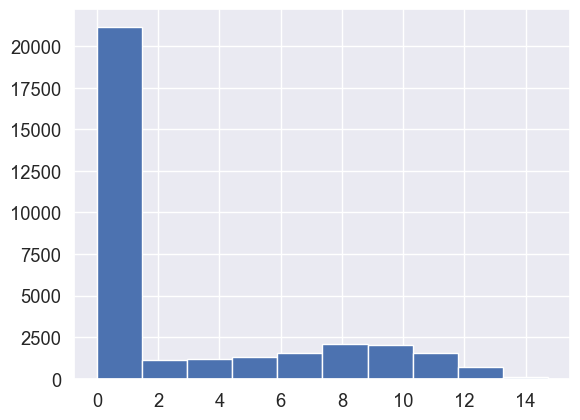

In [3]:
# (106, 56322)
plt.hist(speed_run) # (56302)
plt.show()

Naive model fitting:
Ignore running / stationary, fit model to both data.

### Preprocessing

#### Convolve spikes

In [4]:
spks_stim_rates = rbf_rate_convolution_2d(spks_stim.T, sigma=0.1) # [93996, 106]
n_output_neurons, n_bins = spks_stim.shape
n_input_neurons = dff_stim.shape[0]
spks_stim_rates = torch.hstack([torch.zeros((n_output_neurons, 50)), spks_stim_rates, torch.zeros((n_output_neurons, 50))])

assert np.array(spks_stim_rates.shape).all() == np.array(spks_stim.shape).all()

spks_stim_rates = spks_stim_rates.T

##### Plot sample

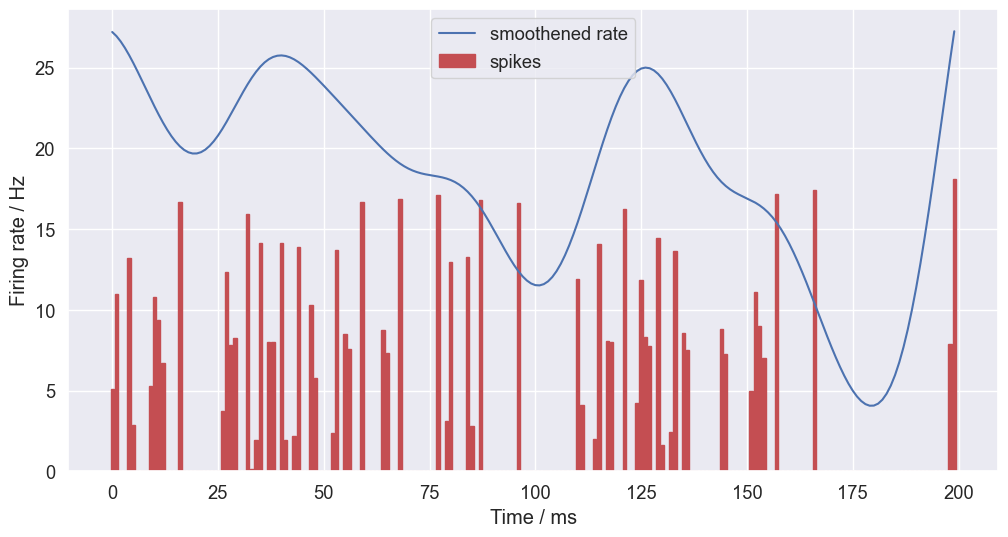

In [5]:
# visualise a sample of ephys smooth rates
_range = 200
_random_start = np.random.randint(0, n_bins-_range)
_random_neuron_idx = np.random.randint(0, n_output_neurons)

plt.figure(figsize=(12,6))
plt.plot(spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx], label='smoothened rate')
plt.bar(np.arange(200), height = spks_stim[_random_neuron_idx, _random_start:_random_start+_range] * spks_stim_rates[_random_start:_random_start+_range, _random_neuron_idx].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

# 10 time steps = 1 sigma = 330 ms

##### Average firing rates of each neuron

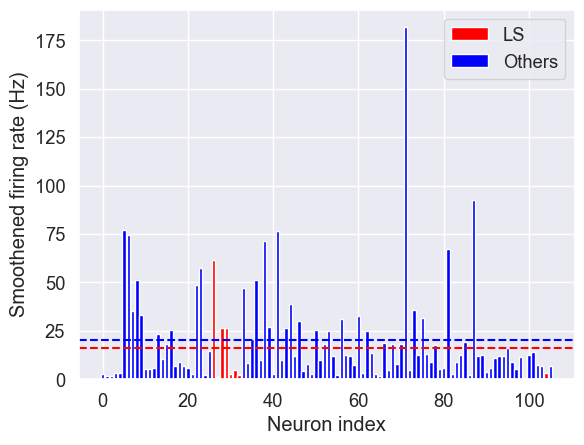

LS neuron firing rate: 16.095746994018555 Hz
non-LS neuron firing rate: 20.01192283630371 Hz


In [6]:
mask1 = area_ID_ephys == 'LS'
mask2 = area_ID_ephys != 'LS'

plt.bar(np.arange(spks_stim_rates.shape[1])[mask1], spks_stim_rates.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates.shape[1])[mask2], spks_stim_rates.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates.mean(0)[mask2].mean()} Hz')

#### Extact stim instances

In [7]:
tsteps = 15
cutoff_size = 1

dff_stim = dff_stim.T

assert dff_stim.shape[0] == spks_stim_rates.shape[0]

n_vecs = int(spks_stim_rates.shape[0] / tsteps)
input_dim = dff_stim.shape[1]
output_dim = spks_stim_rates.shape[1]
n_vecs = int(spks_stim_rates.shape[0]/tsteps)
n_stims = len(stim_ID)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(spks_stim_rates)
img_array = torch.as_tensor(dff_stim)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])

# edge case: last stim happens to be in the last bin.
# stim_vecs_idx = stim_vecs_idx[:-1]

non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

# non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [8]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

## Training

### LS Neurons

In [9]:
LS_neuron_idx = np.where(area_ID_ephys == 'LS')[0]
ACC_neuron_idx = np.where(area_ID_ephys == 'ACC')[0]
Others_neuron_idx = np.where(area_ID_ephys == 'Other')[0]
nLS_neuron_idx = np.where(area_ID_ephys != 'LS')[0]

# randomise valid idx
n_non_stim = len(Y_train)
valid_idx = np.random.choice(np.arange(len(Y_train)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y_train))) - set(valid_idx))))


forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [10]:
# 8 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
Y_valid_LS = Y_train[valid_idx,:,:][..., LS_neuron_idx]

output_dim = len(LS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_LS)
train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=True)
valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_LS)
valid_dataloader_LS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)
del train_dataset, test_dataset, valid_dataset

# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability

#### Bayes Opt

In [12]:
_run = True
from bayes_opt import BayesianOptimization
from models import TransformerOneStep
from train import train_transformer, eval_transformer
from utils import count_parameters

LS_param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    LS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=200, n_iter=200):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=123)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run:
    run_bayes_opt(pbounds = {'d_model':(100, 2000), 'num_heads':(1, 30), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=200, n_iter=200)
    np.save(f'./data/trained_models/EB095-stim-LS-param_counts.npy', np.array(LS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 48%|████▊     | 119/250 [02:10<02:23,  1.10s/it]


| 1         | -148.0    | 1.423e+03 | 357.5     | 1.907     | 16.99     |


 34%|███▎      | 84/250 [06:53<13:36,  4.92s/it]


| 2         | -303.7    | 1.467e+03 | 480.8     | 4.923     | 20.86     |


 47%|████▋     | 118/250 [02:41<03:00,  1.37s/it]


| 3         | -157.6    | 1.014e+03 | 452.9     | 2.373     | 22.14     |


 44%|████▎     | 109/250 [02:15<02:54,  1.24s/it]


| 4         | -162.2    | 933.3     | 153.7     | 2.592     | 22.4      |


 69%|██████▉   | 172/250 [02:20<01:03,  1.22it/s]


| 5         | -130.5    | 446.7     | 257.9     | 3.126     | 16.42     |


 46%|████▌     | 114/250 [06:06<07:17,  3.21s/it]


| 6         | -162.8    | 1.305e+03 | 864.5     | 3.898     | 18.72     |


 44%|████▍     | 111/250 [04:33<05:42,  2.46s/it]


| 7         | -158.2    | 1.473e+03 | 390.7     | 2.447     | 7.62      |


 52%|█████▏    | 130/250 [01:08<01:03,  1.89it/s]


| 8         | -147.3    | 658.1     | 667.9     | 1.368     | 13.58     |


 51%|█████     | 128/250 [02:48<02:40,  1.31s/it]


| 9         | -146.9    | 918.6     | 544.3     | 2.703     | 10.06     |


 41%|████      | 102/250 [04:39<06:45,  2.74s/it]


| 10        | -273.5    | 910.1     | 904.1     | 4.777     | 15.55     |


 46%|████▌     | 114/250 [03:42<04:25,  1.95s/it]


| 11        | -157.1    | 1.286e+03 | 204.1     | 2.269     | 13.03     |


 50%|█████     | 126/250 [06:51<06:44,  3.26s/it]


| 12        | -157.3    | 1.746e+03 | 325.4     | 2.932     | 29.58     |


 43%|████▎     | 107/250 [01:37<02:10,  1.09it/s]


| 13        | -156.5    | 1.087e+03 | 651.6     | 1.483     | 24.96     |


 46%|████▋     | 116/250 [03:51<04:26,  1.99s/it]


| 14        | -162.5    | 1.246e+03 | 590.6     | 2.371     | 9.82      |


 39%|███▉      | 97/250 [04:13<06:40,  2.62s/it]


| 15        | -201.1    | 892.3     | 713.2     | 4.502     | 15.8      |


 42%|████▏     | 106/250 [05:44<07:47,  3.25s/it]


| 16        | -169.1    | 1.372e+03 | 627.3     | 3.5       | 20.57     |


 37%|███▋      | 93/250 [08:47<14:50,  5.67s/it]


| 17        | -182.6    | 1.7e+03   | 174.9     | 4.055     | 8.066     |


 50%|█████     | 125/250 [00:52<00:52,  2.37it/s]


| 18        | -147.9    | 469.0     | 615.2     | 1.383     | 26.67     |


 42%|████▏     | 105/250 [01:55<02:39,  1.10s/it]


| 19        | -153.8    | 1.292e+03 | 751.1     | 1.065     | 18.24     |


 42%|████▏     | 106/250 [01:42<02:19,  1.04it/s]


| 20        | -153.6    | 1.158e+03 | 243.1     | 1.612     | 21.17     |


 52%|█████▏    | 130/250 [02:54<02:40,  1.34s/it]


| 21        | -150.7    | 705.7     | 722.8     | 3.218     | 12.28     |


 41%|████      | 102/250 [06:08<08:54,  3.61s/it]


| 22        | -181.9    | 1.858e+03 | 857.5     | 2.43      | 2.264     |


 54%|█████▎    | 134/250 [03:18<02:51,  1.48s/it]


| 23        | -158.5    | 679.1     | 458.4     | 3.82      | 29.87     |


 52%|█████▏    | 129/250 [03:34<03:21,  1.66s/it]


| 24        | -155.4    | 776.2     | 786.3     | 3.373     | 21.06     |


 58%|█████▊    | 144/250 [00:40<00:29,  3.58it/s]


| 25        | -148.0    | 387.1     | 459.0     | 1.963     | 10.96     |


 46%|████▌     | 115/250 [01:49<02:08,  1.05it/s]


| 26        | -160.7    | 1.075e+03 | 700.0     | 1.424     | 4.796     |


 41%|████      | 102/250 [03:18<04:48,  1.95s/it]


| 27        | -249.0    | 711.8     | 695.4     | 4.386     | 17.04     |


 38%|███▊      | 95/250 [05:03<08:14,  3.19s/it]


| 28        | -165.8    | 1.723e+03 | 446.4     | 2.267     | 11.27     |


 76%|███████▌  | 190/250 [02:12<00:41,  1.44it/s]


| 29        | -132.2    | 425.1     | 846.2     | 2.355     | 17.02     |


 39%|███▉      | 98/250 [01:44<02:42,  1.07s/it]


| 30        | -157.0    | 1.199e+03 | 569.4     | 1.011     | 29.66     |


 49%|████▉     | 123/250 [06:53<07:07,  3.36s/it]


| 31        | -154.0    | 1.82e+03  | 286.9     | 2.17      | 16.08     |


 44%|████▍     | 111/250 [07:22<09:14,  3.99s/it]


| 32        | -159.3    | 1.814e+03 | 985.3     | 2.03      | 17.37     |


 38%|███▊      | 95/250 [07:48<12:44,  4.93s/it]


| 33        | -193.3    | 1.633e+03 | 454.9     | 3.924     | 5.671     |


 36%|███▌      | 90/250 [05:55<10:31,  3.95s/it]


| 34        | -248.3    | 1.241e+03 | 879.3     | 4.934     | 3.302     |


 55%|█████▍    | 137/250 [02:43<02:14,  1.19s/it]


| 35        | -143.3    | 913.9     | 284.1     | 2.803     | 16.89     |


 81%|████████  | 202/250 [02:44<00:38,  1.23it/s]


| 36        | -123.9    | 277.3     | 367.2     | 4.71      | 17.5      |


 46%|████▋     | 116/250 [03:53<04:29,  2.01s/it]


| 37        | -206.9    | 969.1     | 778.2     | 3.967     | 2.409     |


 41%|████      | 103/250 [02:18<03:17,  1.34s/it]


| 38        | -157.7    | 1.447e+03 | 855.3     | 1.664     | 23.65     |


 53%|█████▎    | 133/250 [02:27<02:10,  1.11s/it]


| 39        | -154.3    | 644.4     | 375.8     | 3.661     | 4.23      |


 46%|████▋     | 116/250 [06:28<07:28,  3.35s/it]


| 40        | -203.3    | 1.363e+03 | 899.1     | 3.785     | 13.77     |


 42%|████▏     | 105/250 [03:33<04:54,  2.03s/it]


| 41        | -197.1    | 932.6     | 788.6     | 3.263     | 3.462     |


 40%|████      | 100/250 [03:18<04:57,  1.98s/it]


| 42        | -160.5    | 1.207e+03 | 833.4     | 2.348     | 27.9      |


 38%|███▊      | 95/250 [07:43<12:36,  4.88s/it]


| 43        | -269.5    | 1.526e+03 | 616.7     | 4.007     | 3.295     |


 36%|███▌      | 90/250 [09:42<17:15,  6.47s/it]


| 44        | -267.7    | 1.733e+03 | 839.4     | 4.639     | 4.73      |


 73%|███████▎  | 183/250 [01:10<00:25,  2.59it/s]


| 45        | -143.0    | 255.4     | 224.6     | 2.598     | 13.3      |


 45%|████▌     | 113/250 [01:34<01:54,  1.20it/s]


| 46        | -150.7    | 1.168e+03 | 210.0     | 1.806     | 24.54     |


 46%|████▌     | 114/250 [01:25<01:42,  1.33it/s]


| 47        | -150.4    | 989.2     | 827.1     | 1.03      | 17.0      |


 39%|███▉      | 98/250 [03:10<04:54,  1.94s/it]


| 48        | -155.7    | 1.871e+03 | 624.0     | 1.824     | 21.81     |


 52%|█████▏    | 130/250 [01:20<01:14,  1.62it/s]


| 49        | -147.0    | 820.1     | 701.5     | 1.117     | 19.44     |


 79%|███████▉  | 197/250 [00:51<00:13,  3.80it/s]


| 50        | -132.3    | 161.2     | 770.3     | 2.892     | 4.531     |


 46%|████▋     | 116/250 [04:45<05:29,  2.46s/it]


| 51        | -159.0    | 1.131e+03 | 160.1     | 3.613     | 29.89     |


 47%|████▋     | 118/250 [02:54<03:15,  1.48s/it]


| 52        | -146.2    | 1.562e+03 | 616.4     | 1.411     | 21.3      |


 35%|███▌      | 88/250 [05:21<09:52,  3.66s/it]


| 53        | -236.7    | 1.356e+03 | 144.2     | 4.169     | 16.04     |


 59%|█████▉    | 147/250 [03:01<02:06,  1.23s/it]


| 54        | -139.4    | 909.1     | 809.4     | 2.646     | 14.95     |


 68%|██████▊   | 169/250 [02:42<01:17,  1.04it/s]


| 55        | -113.2    | 445.1     | 389.2     | 4.382     | 6.42      |


 60%|██████    | 150/250 [02:02<01:21,  1.23it/s]


| 56        | -144.3    | 892.9     | 990.1     | 1.946     | 27.59     |


 37%|███▋      | 92/250 [05:13<08:57,  3.40s/it]


| 57        | -162.8    | 1.845e+03 | 182.2     | 2.855     | 15.56     |


 52%|█████▏    | 129/250 [00:53<00:50,  2.41it/s]


| 58        | -163.1    | 696.0     | 142.6     | 1.967     | 3.77      |


 53%|█████▎    | 133/250 [02:53<02:32,  1.30s/it]


| 59        | -177.7    | 552.7     | 827.0     | 4.58      | 2.253     |


 66%|██████▌   | 164/250 [04:02<02:07,  1.48s/it]


| 60        | -130.4    | 673.7     | 982.5     | 3.158     | 19.16     |


 88%|████████▊ | 219/250 [01:52<00:15,  1.94it/s]


| 61        | -142.7    | 110.5     | 536.4     | 4.953     | 11.88     |


 72%|███████▏  | 181/250 [02:10<00:49,  1.39it/s]


| 62        | -122.8    | 284.4     | 515.7     | 4.852     | 10.91     |


 41%|████      | 103/250 [02:39<03:47,  1.54s/it]


| 63        | -152.8    | 1.618e+03 | 819.0     | 1.833     | 13.86     |


 45%|████▌     | 113/250 [02:27<02:59,  1.31s/it]


| 64        | -151.5    | 1.46e+03  | 469.5     | 1.764     | 29.06     |


 44%|████▎     | 109/250 [02:03<02:39,  1.13s/it]


| 65        | -152.2    | 1.336e+03 | 878.9     | 1.101     | 8.74      |


 38%|███▊      | 94/250 [04:17<07:07,  2.74s/it]


| 66        | -225.4    | 1.054e+03 | 160.7     | 4.972     | 7.857     |


 44%|████▍     | 111/250 [00:59<01:14,  1.88it/s]


| 67        | -159.6    | 811.2     | 292.6     | 1.422     | 7.742     |


 51%|█████     | 127/250 [01:52<01:48,  1.13it/s]


| 68        | -142.2    | 671.2     | 671.0     | 2.125     | 11.51     |


 94%|█████████▍| 235/250 [01:09<00:04,  3.40it/s]


| 69        | -143.3    | 111.3     | 429.1     | 3.136     | 5.698     |


 39%|███▉      | 98/250 [03:57<06:08,  2.42s/it]


| 70        | -211.9    | 1.235e+03 | 363.8     | 3.528     | 1.76      |


 44%|████▍     | 110/250 [03:08<03:59,  1.71s/it]


| 71        | -150.0    | 1.786e+03 | 114.5     | 1.508     | 23.54     |


 72%|███████▏  | 181/250 [02:50<01:05,  1.06it/s]


| 72        | -127.1    | 187.2     | 739.9     | 4.884     | 26.28     |


 39%|███▉      | 97/250 [04:16<06:44,  2.65s/it]


| 73        | -161.8    | 1.449e+03 | 962.7     | 2.719     | 26.31     |


 48%|████▊     | 119/250 [01:15<01:22,  1.59it/s]


| 74        | -149.1    | 776.3     | 936.8     | 1.595     | 28.26     |


 41%|████      | 103/250 [02:57<04:13,  1.73s/it]


| 75        | -153.9    | 1.682e+03 | 861.4     | 1.496     | 18.3      |


 87%|████████▋ | 217/250 [00:32<00:04,  6.71it/s]


| 76        | -150.9    | 131.1     | 749.1     | 1.031     | 3.46      |


 60%|██████    | 150/250 [01:54<01:16,  1.31it/s]


| 77        | -132.6    | 528.4     | 887.6     | 2.454     | 16.66     |


 48%|████▊     | 120/250 [04:50<05:14,  2.42s/it]


| 78        | -165.2    | 1.179e+03 | 302.9     | 3.289     | 20.17     |


 60%|██████    | 151/250 [02:24<01:34,  1.04it/s]


| 79        | -135.6    | 666.7     | 476.8     | 2.812     | 28.04     |


 47%|████▋     | 117/250 [05:53<06:42,  3.02s/it]


| 80        | -170.9    | 1.216e+03 | 953.4     | 3.224     | 15.52     |


 84%|████████▍ | 211/250 [01:26<00:15,  2.44it/s]


| 81        | -153.0    | 106.7     | 532.8     | 4.71      | 6.753     |


 76%|███████▋  | 191/250 [01:30<00:28,  2.10it/s]


| 82        | -140.9    | 199.0     | 466.1     | 2.49      | 25.86     |


 74%|███████▍  | 185/250 [02:17<00:48,  1.35it/s]


| 83        | -140.1    | 150.6     | 928.1     | 3.724     | 27.22     |


 43%|████▎     | 108/250 [03:40<04:49,  2.04s/it]


| 84        | -162.8    | 1.254e+03 | 830.8     | 2.342     | 11.14     |


 43%|████▎     | 108/250 [02:03<02:43,  1.15s/it]


| 85        | -151.8    | 840.8     | 779.3     | 2.477     | 8.024     |


 38%|███▊      | 95/250 [06:10<10:04,  3.90s/it]


| 86        | -162.7    | 1.882e+03 | 917.2     | 2.395     | 19.4      |


 48%|████▊     | 119/250 [01:22<01:30,  1.44it/s]


| 87        | -148.8    | 620.3     | 285.5     | 2.345     | 10.49     |


 37%|███▋      | 92/250 [07:49<13:26,  5.10s/it]


| 88        | -228.1    | 1.776e+03 | 840.1     | 3.838     | 28.82     |


 50%|████▉     | 124/250 [01:18<01:19,  1.59it/s]


| 89        | -153.3    | 902.8     | 320.5     | 1.47      | 9.731     |


 69%|██████▉   | 172/250 [01:47<00:48,  1.59it/s]


| 90        | -133.4    | 376.0     | 183.0     | 3.412     | 11.56     |


 50%|█████     | 126/250 [04:59<04:54,  2.38s/it]


| 91        | -175.6    | 1.173e+03 | 272.2     | 3.708     | 7.25      |


 63%|██████▎   | 158/250 [02:58<01:43,  1.13s/it]


| 92        | -126.0    | 628.2     | 767.6     | 3.239     | 10.71     |


 36%|███▋      | 91/250 [05:24<09:26,  3.57s/it]


| 93        | -217.7    | 1.132e+03 | 724.6     | 4.649     | 17.84     |


 68%|██████▊   | 170/250 [03:47<01:46,  1.34s/it]


| 94        | -116.5    | 542.1     | 772.0     | 4.111     | 6.812     |


 39%|███▉      | 97/250 [09:52<15:34,  6.11s/it]


| 95        | -261.1    | 1.659e+03 | 518.4     | 4.119     | 7.887     |


 48%|████▊     | 121/250 [03:18<03:31,  1.64s/it]


| 96        | -149.3    | 731.9     | 958.3     | 3.631     | 23.41     |


 45%|████▍     | 112/250 [03:50<04:43,  2.06s/it]


| 97        | -153.6    | 1.408e+03 | 283.9     | 2.883     | 24.46     |


 47%|████▋     | 118/250 [02:06<02:22,  1.08s/it]


| 98        | -148.4    | 1.383e+03 | 105.4     | 1.35      | 11.06     |


 42%|████▏     | 104/250 [06:17<08:49,  3.63s/it]


| 99        | -164.8    | 1.894e+03 | 542.1     | 2.081     | 11.45     |


 49%|████▉     | 122/250 [00:51<00:54,  2.36it/s]


| 100       | -153.2    | 500.2     | 479.1     | 1.872     | 25.53     |


 46%|████▋     | 116/250 [04:35<05:18,  2.38s/it]


| 101       | -184.8    | 966.9     | 351.8     | 4.732     | 10.12     |


 41%|████      | 102/250 [08:31<12:21,  5.01s/it]


| 102       | -172.3    | 1.828e+03 | 139.1     | 3.828     | 15.03     |


 47%|████▋     | 117/250 [01:15<01:25,  1.55it/s]


| 103       | -156.0    | 944.0     | 132.7     | 1.163     | 10.65     |


 12%|█▏        | 29/250 [01:54<14:36,  3.96s/it]


KeyboardInterrupt: 

#### Train Transformer

In [13]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 55        | -113.2    | 445.1     | 389.2     | 4.382     | 6.42      |
# | 5         | -130.5    | 446.7     | 257.9     | 3.126     | 16.42     |

d_model = 445
num_heads = 6
hidden_dim = 389
n_layers = 4

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)


assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

In [17]:
# import wandb
# wandb.login()
# wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                    mode='min', 
                                                    factor=0.5, 
                                                    patience=10, 
                                                    threshold=0.01)
num_epochs = 500

# from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_LS,
            train_loader=train_dataloader_LS,
            test_loader=test_dataloader_LS,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            batch_first=True,
            scheduler=scheduler,
            use_wandb=False,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

 21%|██▏       | 107/500 [01:46<06:31,  1.00it/s]


In [19]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs}
        }

torch.save(return_dict['best_eval_params'], save_path / f'EB095-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk2.pth')
with open(save_path / f'EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk2.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk2')

Saved model parameters and training stats to ./save/trained_models/EB095-stim-LS-transformer-param-metadata-444-6-389-4-mk2


In [18]:
# with open(save_path / 'EB095-stim-LS-transformer-param-metadata.pkl', 'rb') as f:
#     data = pickle.load(f)
# best_eval_params = torch.load(save_path /f'EB095-stim-LS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}-mk2.pth')
# DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(123.3287)
Transformer prediction for forward stim MSE loss:  tensor(113.6790)
Transformer prediction for backward stim MSE loss:  tensor(142.6299)
Transformer prediction for random stim MSE loss:  tensor(106.1182)
Transformer prediction for non-stim stim MSE loss:  tensor(126.9256)


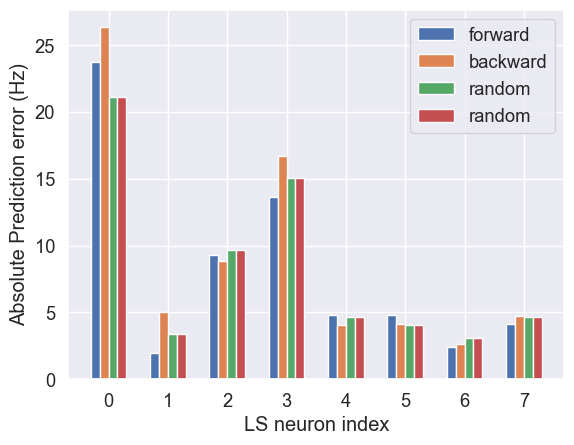

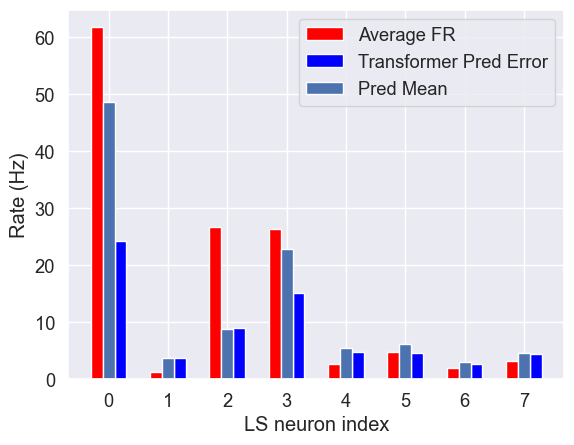

In [20]:
plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.225, torch.sqrt(LS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.075, torch.sqrt(LS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.075, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.225, torch.sqrt(LS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')

plt.xlabel('LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.2, spks_stim_rates.mean(0)[mask1], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.2, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_LS_np
    plt.bar(np.arange(len(LS_neuron_idx)), np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

#### Train GLM

In [21]:
from loguru import logger
from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (500, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='auto')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')

logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

np.save(save_path / 'EB095-stim-LS-glm-losses.npy', glm_LS_losses)

2024-02-29 23:45:31.230 | INFO     | __main__:<module>:13 - Loss for LS neuron No 0: 797.389125 (Hz^2).
2024-02-29 23:45:31.230 | INFO     | __main__:<module>:14 - Forward: 1010.136484375, Backward: 885.458849009901, Random: 676.3661616161617. Endogenous: 706.446640625
2024-02-29 23:45:37.051 | INFO     | __main__:<module>:13 - Loss for LS neuron No 1: 13.506560546875 (Hz^2).
2024-02-29 23:45:37.052 | INFO     | __main__:<module>:14 - Forward: 2.4433837890625, Backward: 22.417874477877476, Random: 10.367710306186869. Endogenous: 16.091663818359375
2024-02-29 23:45:43.077 | INFO     | __main__:<module>:13 - Loss for LS neuron No 2: 63.68723828125 (Hz^2).
2024-02-29 23:45:43.078 | INFO     | __main__:<module>:14 - Forward: 55.32099609375, Backward: 66.10749922648515, Random: 73.09565380366162. Endogenous: 61.990947265625
2024-02-29 23:45:50.586 | INFO     | __main__:<module>:13 - Loss for LS neuron No 3: 273.483625 (Hz^2).
2024-02-29 23:45:50.587 | INFO     | __main__:<module>:14 - Forwa

2024-02-29 23:48:18.417 | INFO     | __main__:<module>:2 - Predicting mean for each of the 8 LS neurons: [2364.6155      14.12673     77.8298     523.6999      29.909973
   38.69283      8.9397135   21.940773 ]


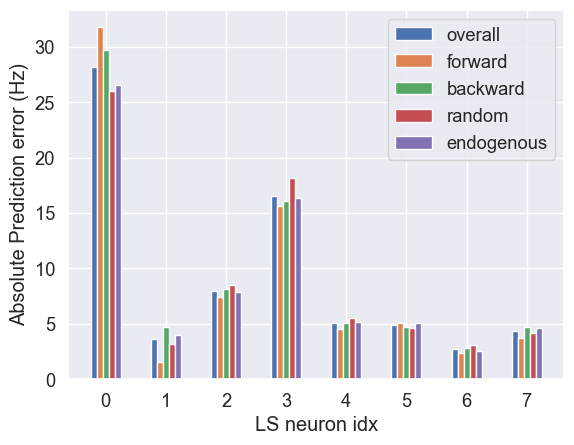

In [22]:
glm_LS_losses = np.load(save_path / 'EB095-stim-LS-glm-losses.npy')
logger.info(f'Predicting mean for each of the 8 LS neurons: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]}')

plt.figure()
plt.bar(np.arange(8)-0.2, np.sqrt(glm_LS_losses.mean(0)), width=0.1, label='overall')
plt.bar(np.arange(8)-0.1, np.sqrt(glm_LS_losses[forward_mse_idx].mean(0)), width=0.1, label='forward')
plt.bar(np.arange(8), np.sqrt(glm_LS_losses[backward_mse_idx].mean(0)), width=0.1, label='backward')
plt.bar(np.arange(8)+0.1, np.sqrt(glm_LS_losses[random_mse_idx].mean(0)), width=0.1, label='random')
plt.bar(np.arange(8)+0.2, np.sqrt(glm_LS_losses[non_stim_mse_idx].mean(0)), width=0.1, label='endogenous')
plt.xlabel('LS neuron idx')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

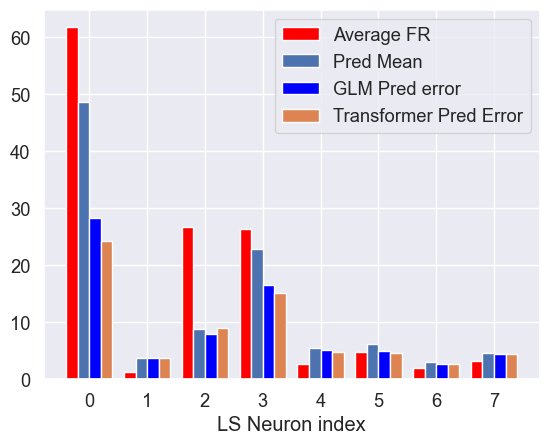

In [23]:
plt.figure()
plt.bar(np.arange(8) - 0.3, spks_stim_rates.mean(0)[mask1], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.1, np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
plt.bar(np.arange(8) + 0.1, np.sqrt(glm_LS_losses.sum(0)/glm_LS_losses.shape[0]), color='blue', width=0.2, label='GLM Pred error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.3, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), width=0.2, label='Transformer Pred Error')
plt.legend()
plt.xlabel('LS Neuron index')
plt.show()

#### Train RNN

In [12]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import RecurrentDNN
from train import train_rnn
from utils import count_parameters

LS_rnn_param_counts = []

import gc
def black_box_function(hidden_dim, n_rec_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim = int(hidden_dim)
    n_rec_layers = int(n_rec_layers)
    
    rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=n_rec_layers, 
                output_dim=output_dim, 
                n_input_layers=0,
                n_output_layers=1,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)
    
    optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_rnn(
        model=rnn, 
        train_loader=train_dataloader_LS, 
        test_loader=test_dataloader_LS, 
        optimiser = optimiser, 
        criterion = criterion, 
        num_epochs = 500, 
        verbose=False, 
        force_stop=False, 
        scheduler=scheduler)

    LS_rnn_param_counts.append([min(return_dict['eval_losses']), count_parameters(rnn), n_rec_layers, hidden_dim])
    valid_loss = -min(return_dict['eval_losses'])   
    del rnn, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'hidden_dim':(10, 1000), 'n_rec_layers':(1, 4)}, init_points=50, n_iter=50)
    np.save(f'./data/trained_models/EB095-stim-LS-rnn-param_counts.npy', np.array(LS_rnn_param_counts))

|   iter    |  target   | hidden... | n_rec_... |
-------------------------------------------------


 25%|██▍       | 124/500 [07:04<21:25,  3.42s/it]


| 1         | -397.3    | 422.9     | 3.161     |


100%|██████████| 500/500 [02:06<00:00,  3.95it/s]


| 2         | -580.5    | 10.11     | 1.907     |


 36%|███▌      | 181/500 [01:35<02:48,  1.90it/s]


| 3         | -399.2    | 155.3     | 1.277     |


 33%|███▎      | 165/500 [02:38<05:21,  1.04it/s]


| 4         | -486.0    | 194.4     | 2.037     |


 24%|██▍       | 121/500 [04:20<13:35,  2.15s/it]


| 5         | -397.3    | 402.8     | 2.616     |


 25%|██▌       | 127/500 [07:09<21:00,  3.38s/it]


| 6         | -397.4    | 425.0     | 3.056     |


 31%|███       | 155/500 [03:47<08:25,  1.47s/it]


| 7         | -398.2    | 212.4     | 3.634     |


 31%|███▏      | 157/500 [01:09<02:32,  2.26it/s]


| 8         | -917.0    | 37.11     | 3.011     |


 25%|██▍       | 123/500 [04:41<14:22,  2.29s/it]


| 9         | -397.3    | 423.1     | 2.676     |


 35%|███▌      | 177/500 [01:32<02:48,  1.92it/s]


| 10        | -400.9    | 149.0     | 1.594     |


 19%|█▉        | 94/500 [14:33<1:02:53,  9.30s/it]


| 11        | -397.2    | 802.7     | 3.905     |


 26%|██▋       | 132/500 [04:56<13:45,  2.24s/it]


| 12        | -397.5    | 320.3     | 3.077     |


 19%|█▉        | 96/500 [17:06<1:11:58, 10.69s/it]


| 13        | -397.2    | 877.6     | 3.684     |


 47%|████▋     | 234/500 [01:30<01:42,  2.59it/s]


| 14        | -403.5    | 94.19     | 1.117     |


 34%|███▍      | 171/500 [03:21<06:27,  1.18s/it]


| 15        | -398.8    | 178.1     | 3.634     |


 43%|████▎     | 217/500 [02:01<02:38,  1.79it/s]


| 16        | -401.3    | 107.4     | 2.263     |


 18%|█▊        | 90/500 [12:46<58:11,  8.52s/it]  


| 17        | -397.1    | 958.3     | 2.599     |


 19%|█▉        | 97/500 [03:40<15:17,  2.28s/it]


| 18        | -397.2    | 695.0     | 1.947     |


 19%|█▉        | 97/500 [11:07<46:12,  6.88s/it]


| 19        | -397.3    | 689.6     | 3.504     |


 88%|████████▊ | 438/500 [02:32<00:21,  2.88it/s]


| 20        | -432.3    | 28.11     | 3.25      |


 20%|█▉        | 98/500 [21:29<1:28:09, 13.16s/it]


| 21        | -397.2    | 989.0     | 3.244     |


 27%|██▋       | 137/500 [04:36<12:11,  2.02s/it]


| 22        | -397.7    | 287.6     | 3.368     |


 43%|████▎     | 215/500 [02:05<02:46,  1.71it/s]


| 23        | -401.0    | 112.2     | 2.344     |


 18%|█▊        | 91/500 [04:52<21:56,  3.22s/it]


| 24        | -397.2    | 909.5     | 1.881     |


 28%|██▊       | 139/500 [01:52<04:51,  1.24it/s]


| 25        | -397.6    | 294.9     | 1.39      |


 19%|█▉        | 97/500 [00:35<02:26,  2.76it/s]


| 26        | -1.027e+0 | 29.17     | 3.037     |


 31%|███       | 155/500 [01:37<03:37,  1.58it/s]


| 27        | -397.9    | 219.5     | 1.797     |


 22%|██▏       | 109/500 [02:30<09:00,  1.38s/it]


| 28        | -397.3    | 496.7     | 1.16      |


 20%|██        | 101/500 [03:00<11:53,  1.79s/it]


| 29        | -397.3    | 578.4     | 1.44      |


 20%|██        | 102/500 [10:00<39:01,  5.88s/it]


| 30        | -397.3    | 593.4     | 3.099     |


 43%|████▎     | 215/500 [02:10<02:53,  1.64it/s]


| 31        | -402.5    | 111.3     | 2.242     |


 20%|██        | 100/500 [07:44<30:59,  4.65s/it]


| 32        | -397.3    | 697.5     | 2.243     |


 63%|██████▎   | 313/500 [02:13<01:19,  2.35it/s]


| 33        | -407.8    | 59.45     | 2.608     |


 20%|█▉        | 98/500 [07:16<29:52,  4.46s/it]


| 34        | -397.2    | 667.2     | 2.545     |


 19%|█▉        | 95/500 [12:03<51:24,  7.62s/it]  


| 35        | -397.2    | 945.1     | 2.76      |


 18%|█▊        | 91/500 [04:43<21:13,  3.11s/it]


| 36        | -397.1    | 904.4     | 1.412     |


 35%|███▌      | 177/500 [02:58<05:25,  1.01s/it]


| 37        | -400.5    | 147.9     | 3.422     |


 24%|██▍       | 122/500 [02:15<07:00,  1.11s/it]


| 38        | -397.3    | 403.7     | 1.496     |


 19%|█▉        | 96/500 [11:43<49:22,  7.33s/it]  


| 39        | -397.2    | 928.2     | 2.043     |


 19%|█▉        | 97/500 [13:43<57:02,  8.49s/it]  


| 40        | -397.2    | 753.3     | 3.178     |


 20%|██        | 100/500 [11:24<45:38,  6.85s/it]


| 41        | -397.2    | 884.5     | 2.871     |


 19%|█▉        | 97/500 [09:03<37:36,  5.60s/it]


| 42        | -397.2    | 753.4     | 2.047     |


 26%|██▋       | 132/500 [04:23<12:15,  2.00s/it]


| 43        | -398.0    | 277.2     | 3.688     |


 25%|██▍       | 123/500 [07:07<21:50,  3.48s/it]


| 44        | -397.3    | 433.8     | 3.895     |


 19%|█▉        | 97/500 [07:04<29:24,  4.38s/it]


| 45        | -397.3    | 666.8     | 2.865     |


 43%|████▎     | 213/500 [02:51<03:51,  1.24it/s]


| 46        | -399.7    | 123.6     | 3.848     |


 23%|██▎       | 114/500 [04:43<16:00,  2.49s/it]


| 47        | -397.4    | 455.4     | 2.735     |


 25%|██▍       | 123/500 [02:22<07:17,  1.16s/it]


| 48        | -397.3    | 414.1     | 1.711     |


 18%|█▊        | 91/500 [10:50<48:45,  7.15s/it]  


| 49        | -397.2    | 904.3     | 2.721     |


100%|██████████| 500/500 [02:22<00:00,  3.51it/s]


| 50        | -534.8    | 12.84     | 2.851     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 51        | -397.3    | 424.0     | 3.329     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 52        | -437.7    | 27.22     | 3.217     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 53        | -401.0    | 157.8     | 2.886     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 54        | -401.6    | 95.21     | 3.276     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 55        | -397.3    | 402.6     | 1.495     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 56        | -397.3    | 424.2     | 2.041     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 57        | -397.3    | 696.3     | 2.021     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 58        | -397.2    | 903.2     | 2.114     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 59        | -397.3    | 404.1     | 2.723     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 60        | -400.4    | 157.0     | 2.22      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 61        | -495.0    | 76.14     | 2.603     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 62        | -397.2    | 754.4     | 2.575     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 63        | -398.5    | 199.0     | 3.02      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 64        | -397.2    | 910.7     | 2.248     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 65        | -398.4    | 176.4     | 3.052     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 66        | -397.3    | 593.5     | 3.237     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 67        | -397.2    | 909.6     | 3.354     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 68        | -397.2    | 695.7     | 3.37      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 69        | -397.2    | 911.1     | 3.634     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 70        | -397.2    | 697.3     | 3.661     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 71        | -397.2    | 945.1     | 2.802     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 72        | -397.3    | 694.1     | 3.416     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 73        | -399.6    | 177.8     | 2.221     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 74        | -400.7    | 155.5     | 2.871     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 75        | -397.2    | 698.8     | 3.172     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 76        | -397.2    | 699.1     | 1.575     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 77        | -398.6    | 176.4     | 1.445     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 78        | -399.4    | 156.8     | 3.986     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 79        | -397.1    | 908.1     | 2.689     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 80        | -397.3    | 693.3     | 2.011     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 81        | -397.2    | 905.9     | 2.189     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 82        | -397.2    | 906.8     | 3.555     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 83        | -397.2    | 907.2     | 1.266     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 84        | -397.3    | 691.9     | 2.97      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 85        | -397.3    | 690.6     | 2.034     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 86        | -397.2    | 690.8     | 3.981     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 87        | -397.3    | 700.4     | 2.591     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 88        | -397.3    | 691.8     | 1.195     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 89        | -397.2    | 912.3     | 2.811     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 90        | -397.2    | 700.6     | 1.097     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 91        | -397.2    | 905.2     | 3.899     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 92        | -398.5    | 175.0     | 2.249     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 93        | -397.1    | 903.5     | 3.926     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 94        | -397.1    | 912.2     | 1.251     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 95        | -397.2    | 902.1     | 3.24      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 96        | -397.2    | 913.6     | 1.626     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 97        | -397.2    | 701.9     | 1.94      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 98        | -397.2    | 701.7     | 3.491     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 99        | -397.2    | 913.9     | 3.202     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([709, 1, 8])) that is different to the input size (torch.Size([

| 100       | -397.2    | 915.2     | 2.153     |


FileNotFoundError: [Errno 2] No such file or directory: './data/trained_models/EB095-stim-LS-rnn-param_counts.npy'

In [24]:
# | 13        | -137.7    | 877.6     | 4.578     |
hidden_dim = 512
import copy
from train import train_rnn, eval_rnn
from models import RecurrentDNN


rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=1, 
                output_dim=output_dim, 
                n_input_layers=0,
                n_output_layers=1,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)
    
optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

return_dict = train_rnn(
    model=rnn, 
    train_loader=train_dataloader_LS, 
    test_loader=test_dataloader_LS, 
    optimiser = optimiser, 
    criterion = criterion, 
    num_epochs = 500, 
    verbose=False, 
    force_stop=False, 
    scheduler=scheduler)

with torch.no_grad():
    _, Y_hat_LS_rnn = eval_rnn(rnn, test_dataloader_LS, nn.MSELoss(), True)
    LS_rnn_loss = np.power(Y_test_LS[:,0,:] - Y_hat_LS_rnn.cpu(), 2)

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 8])) that is different to the input size (torch.Size([500, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 8])) that is different to the input size (torch.Size([1024, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([711, 1, 8])) that is different to the input size (torch.Size([711, 8])). This will likely

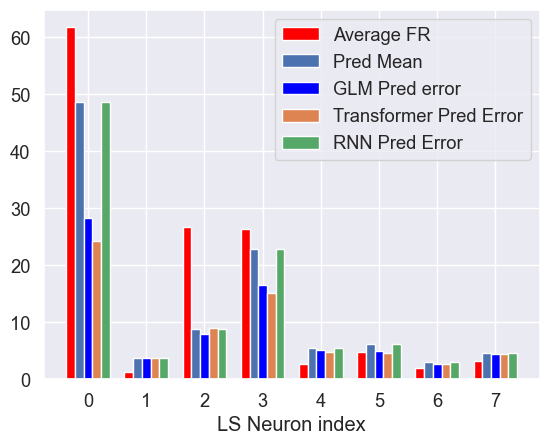

In [25]:
plt.figure()
plt.bar(np.arange(8) - 0.3, spks_stim_rates.mean(0)[mask1], color='red', width=0.15, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) - 0.15, np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.15, label='Pred Mean')
plt.bar(np.arange(8) + 0, np.sqrt(glm_LS_losses.sum(0)/glm_LS_losses.shape[0]), color='blue', width=0.15, label='GLM Pred error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.15, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), width=0.15, label='Transformer Pred Error')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.3, torch.sqrt(LS_rnn_loss.mean(0)), width=0.15, label='RNN Pred Error')

plt.legend()
plt.xlabel('LS Neuron index')
plt.show()

In [59]:
spks_stim_rates[:,LS_neuron_idx].std(axis=0)

tensor([49.3907,  3.8366,  9.1166, 23.2261,  5.2115,  6.0618,  2.8000,  4.7385])

In [60]:
spks_stim_rates[:,LS_neuron_idx].mean(axis=0)

tensor([61.7890,  1.2324, 26.6698, 26.3041,  2.6842,  4.7709,  2.0557,  3.2599])

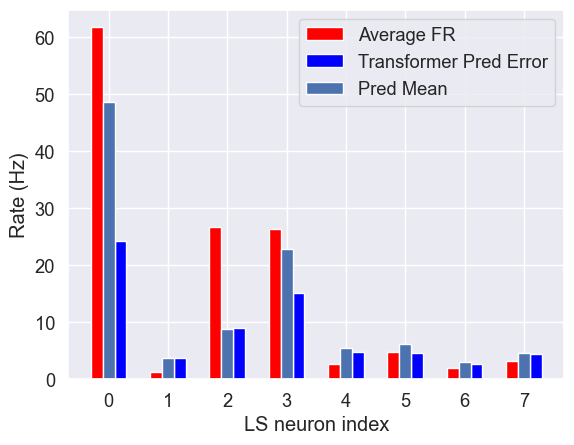

In [26]:
plt.figure()
plt.bar(np.arange(len(LS_neuron_idx)) - 0.2, spks_stim_rates.mean(0)[mask1], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(len(LS_neuron_idx)) + 0.2, torch.sqrt(LS_test_pred_loss.sum(0)[0]/LS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_LS_np
    plt.bar(np.arange(len(LS_neuron_idx)), np.sqrt(np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

### Non-LS neurons

In [37]:
Y_train_nLS = Y_train[train_idx,:,:][..., nLS_neuron_idx]
Y_test_nLS = Y_test[..., nLS_neuron_idx]
Y_valid_nLS = Y_train[valid_idx,:,:][..., nLS_neuron_idx]

output_dim = len(nLS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_nLS)
train_dataloader_nLS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_nLS)
test_dataloader_nLS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)

valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_nLS)
valid_dataloader_nLS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

#### Bayes Opt

In [27]:
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer
import gc

nLS_param_counts = []
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)
    
    nLS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN)])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

np.save(f'./data/trained_models/EB095-stim-LS-param_counts.npy', np.array(nLS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


NameError: name 'train_dataloader' is not defined

#### Train Transformer

In [38]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 6         | -149.4    | 820.7     | 971.4     | 2.254     | 14.15     |

d_model = 820
num_heads = 14
hidden_dim = 971
n_layers = 2

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model %2 != 0:
    d_model += num_heads

DNN_nLS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [40]:
# import wandb
# wandb.login()
# wandb.init(project='approx_brain')

optimiser = torch.optim.Adam(DNN_nLS.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                    mode='min', 
                                                    factor=0.5, 
                                                    patience=10, 
                                                    threshold=0.01)
num_epochs = 800

from train import train_transformer, eval_transformer

return_dict = train_transformer(
            model=DNN_nLS,
            train_loader=train_dataloader_nLS,
            test_loader=test_dataloader_nLS,
            optimiser=optimiser,
            criterion=criterion,
            num_epochs=num_epochs,
            verbose=False,
            batch_first=True,
            scheduler=scheduler,
            use_wandb=False,
            stim_type_indices=
            [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

 21%|██        | 165/800 [03:23<13:01,  1.23s/it]


#### Save Transformer

In [43]:
# optional: save trained model
import datetime
import os
import pickle

timestamp = '-'.join(str(datetime.datetime.now()).split(' '))

data = {'metadata':{'timestamp': timestamp,
                    'save_path': f'./data/biological/trained_models/'},
        'params':{'seed':seed,
                    'sigma': 0.1,
                    'batch_size': batch_size,
                    'tsteps': tsteps,
                    'input_dim': input_dim,
                    'd_model': d_model,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'output_dim': output_dim,
                    'n_layers': n_layers,
                    'num_epochs': num_epochs},
        'train_data': return_dict}


torch.save(return_dict['best_eval_params'], save_path / f'EB095-stim-nLS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pth')
with open(save_path / f'EB095-stim-nLS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pkl', 'wb') as f:
    pickle.dump(data, f)
print(f'Saved model parameters and training stats to ./save/trained_models/EB095-stim-nLS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pkl')

Saved model parameters and training stats to ./save/trained_models/EB095-stim-nLS-transformer-param-metadata-812-14-971-2.pkl


In [44]:
# with open(save_path / f'EB095-stim-LS-transformer-param-metadata-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pkl', 'rb') as f:
#     data = pickle.load(f)
# DNN_nLS.load_state_dict(torch.load(save_path / f'EB095-stim-nLS-transformer-param-{d_model}-{num_heads}-{hidden_dim}-{n_layers}.pth'))

with torch.no_grad():
    Y_hat_nLS = DNN_nLS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    nLS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_nLS, Y_test[...,nLS_neuron_idx])
    print('Overall Transformer Loss:', nLS_test_pred_loss.sum()/np.prod(nLS_test_pred_loss.shape))
    print('Transformer prediction for forward stim MSE loss: ', nLS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    print('Transformer prediction for backward stim MSE loss: ', nLS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    print('Transformer prediction for random stim MSE loss: ', nLS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', nLS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(158.2388)
Transformer prediction for forward stim MSE loss:  tensor(152.0831)
Transformer prediction for backward stim MSE loss:  tensor(162.9388)
Transformer prediction for random stim MSE loss:  tensor(164.3593)
Transformer prediction for non-stim stim MSE loss:  tensor(155.9137)


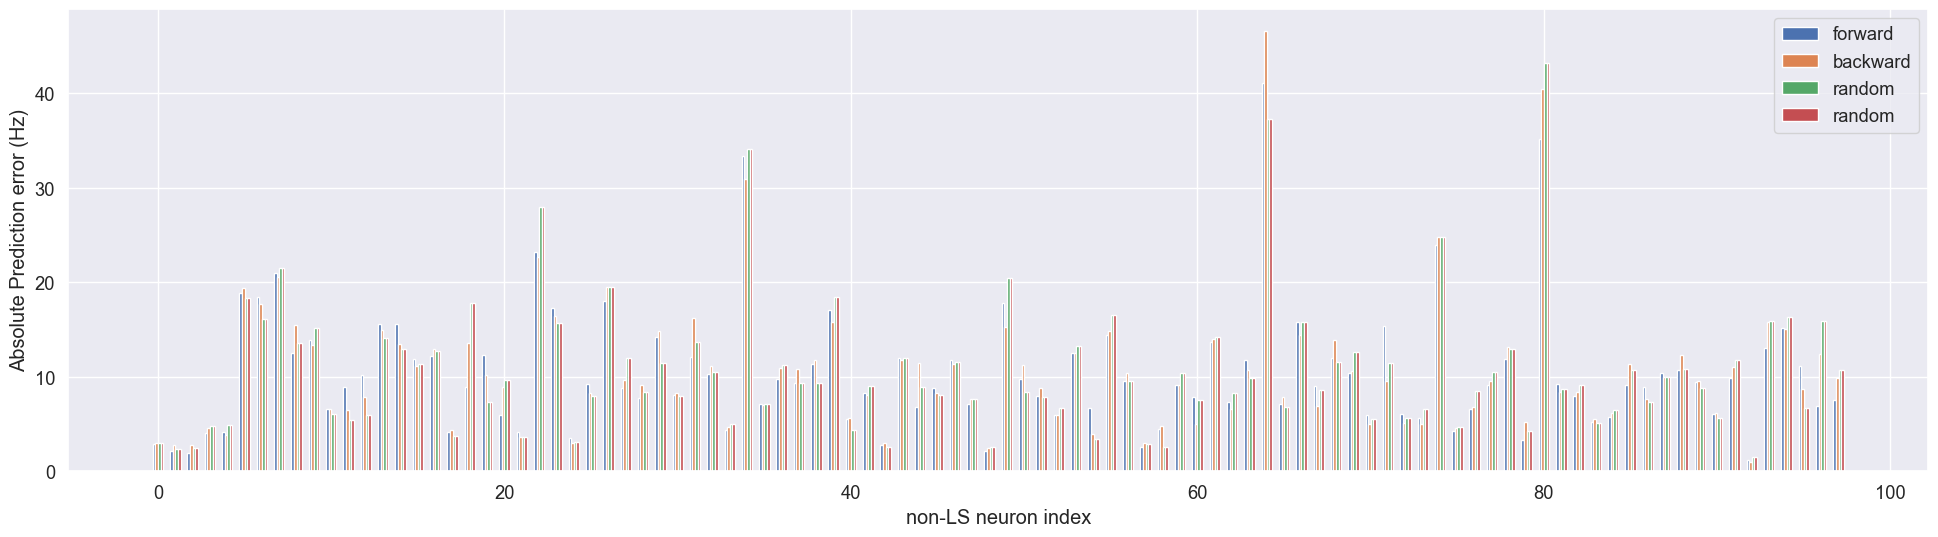

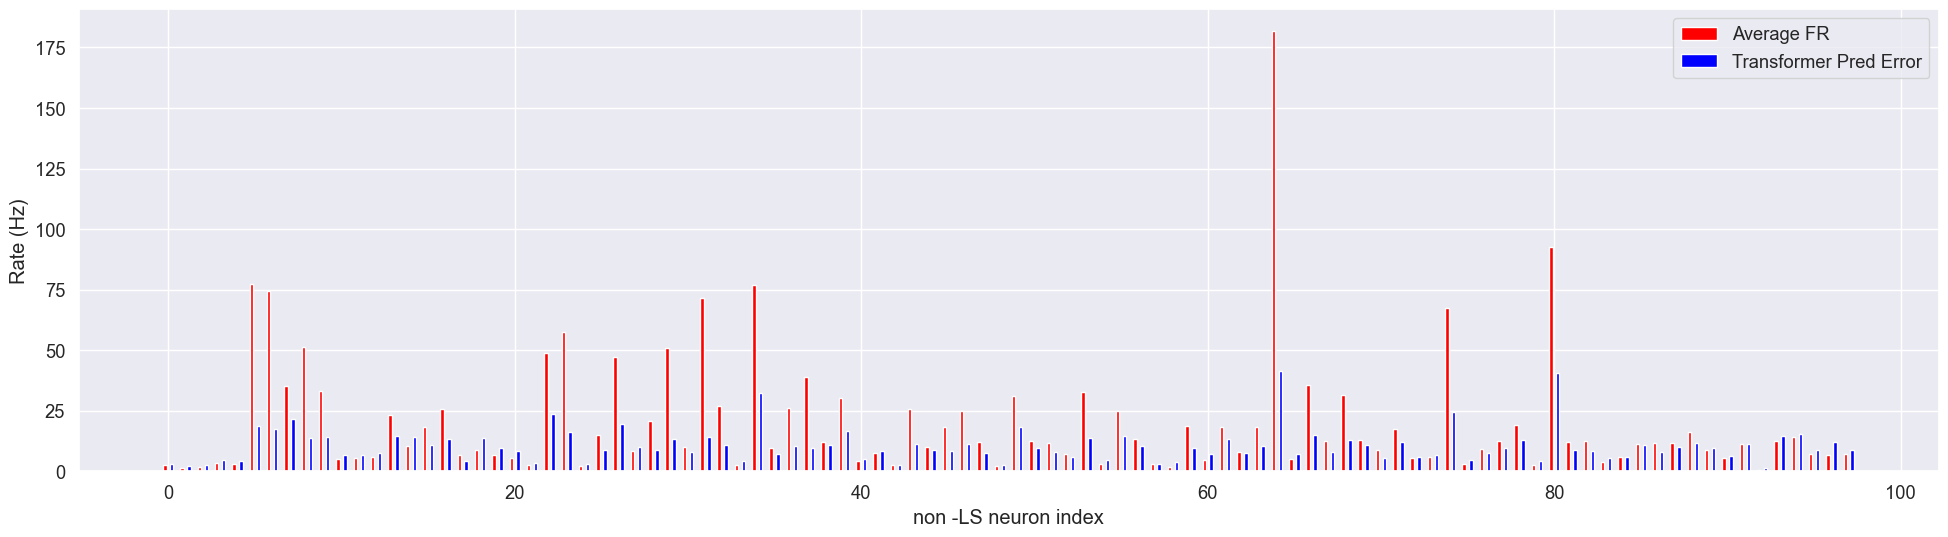

In [45]:
plt.figure(figsize=(24,6))
plt.bar(np.arange(output_dim) - 0.225, torch.sqrt(nLS_test_pred_loss[forward_mse_idx, 0].sum(0)/len(forward_mse_idx)), width=0.15, label='forward')
plt.bar(np.arange(output_dim) - 0.075, torch.sqrt(nLS_test_pred_loss[backward_mse_idx, 0].sum(0)/len(backward_mse_idx)), width=0.15, label='backward')
plt.bar(np.arange(output_dim) + 0.075, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.bar(np.arange(output_dim) + 0.225, torch.sqrt(nLS_test_pred_loss[random_mse_idx, 0].sum(0)/len(random_mse_idx)), width=0.15, label='random')
plt.xlabel('non-LS neuron index')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()

plt.figure(figsize=(24,6))
plt.bar(np.arange(output_dim) - 0.2, spks_stim_rates.mean(0)[mask2], color='red', width=0.2, label='Average FR')
plt.bar(np.arange(output_dim) + 0.2, torch.sqrt(nLS_test_pred_loss.sum(0)[0]/nLS_test_pred_loss.shape[0]), color='blue', width=0.2, label='Transformer Pred Error')
try:
    Y_test_nLS_np
    plt.bar(np.arange(output_dim), np.sqrt(np.power(Y_test_nLS_np - Y_test_nLS_np.mean(0), 2).sum(0) / Y_test_nLS_np.shape[0]), width=0.2, label='Pred Mean')
except: pass

plt.xlabel('non -LS neuron index')
plt.ylabel('Rate (Hz)')
plt.legend()
plt.show()

#### Train GLM

In [46]:
# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_nLS_np = Y_train_nLS.cpu().numpy().reshape(Y_train_nLS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_nLS_np = Y_test_nLS.cpu().numpy().reshape(Y_test_nLS.shape[0],-1) + 1e-6 # numerical stability

output_dim = Y_test_nLS.shape[-1]

from tqdm import tqdm
from sklearn.linear_model import TweedieRegressor

# pred for each neuron
glm_nLS_losses = np.zeros_like(Y_test_nLS_np)
output_dim = Y_test_nLS_np.shape[1]

for i in tqdm(range(output_dim)):
    glm_nLS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
    glm_nLS_reg.fit(X_train_np, Y_train_nLS_np[:,i])
    
    glm_nLS_losses[:,i] += np.power(Y_test_nLS_np[:,i] - glm_nLS_reg.predict(X_test_np), 2)

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 98/98 [10:55<00:00,  6.69s/it]


#### Train RNN

In [41]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import RecurrentDNN
from train import train_rnn
from utils import count_parameters

nLS_rnn_param_counts = []

import gc
def black_box_function(hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim = int(hidden_dim)
    n_layers = int(n_layers)
    
        
    RNN = RecurrentDNN(input_dim=input_dim,
                       hidden_dim=hidden_dim,
                       n_linear_layers=n_layers,
                       n_rec_layers=1,
                       has_input_layer=False,
                       output_dim=output_dim).to(device)
    
    optimiser = torch.optim.Adam(RNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)

    return_dict = train_rnn(
        model=RNN, train_loader=train_dataloader_nLS, test_loader=valid_dataloader_nLS, optimiser = optimiser, criterion = criterion, num_epochs = 400, verbose=False, force_stop=False, scheduler=scheduler)

    nLS_rnn_param_counts.append([min(return_dict['eval_losses']), count_parameters(RNN), hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del RNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'hidden_dim':(10, 1000), 'n_layers':(1, 5)}, init_points=50, n_iter=50)
    np.save(f'./data/trained_models/EB095-stim-LS-rnn-param_counts.npy', np.array(nLS_rnn_param_counts))

|   iter    |  target   | hidden... | n_layers  |
-------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:41<00:00,  2.47it/s]


| 1         | -224.0    | 422.9     | 3.881     |


100%|██████████| 400/400 [01:13<00:00,  5.43it/s]


| 2         | -1.237e+0 | 10.11     | 2.209     |


100%|██████████| 400/400 [01:31<00:00,  4.35it/s]


| 3         | -242.9    | 155.3     | 1.369     |


100%|██████████| 400/400 [01:40<00:00,  3.99it/s]


| 4         | -231.9    | 194.4     | 2.382     |


100%|██████████| 400/400 [02:45<00:00,  2.42it/s]


| 5         | -228.5    | 402.8     | 3.155     |


100%|██████████| 400/400 [02:46<00:00,  2.40it/s]


| 6         | -225.1    | 425.0     | 3.741     |


100%|██████████| 400/400 [01:47<00:00,  3.71it/s]


| 7         | -229.5    | 212.4     | 4.512     |


100%|██████████| 400/400 [01:18<00:00,  5.12it/s]


| 8         | -239.1    | 37.11     | 3.682     |


100%|██████████| 400/400 [02:45<00:00,  2.42it/s]


| 9         | -227.4    | 423.1     | 3.235     |


100%|██████████| 400/400 [01:30<00:00,  4.42it/s]


| 10        | -242.3    | 149.0     | 1.792     |


100%|██████████| 400/400 [06:20<00:00,  1.05it/s]


| 11        | -229.7    | 802.7     | 4.873     |


100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


| 12        | -229.2    | 320.3     | 3.769     |


100%|██████████| 400/400 [07:11<00:00,  1.08s/it]


| 13        | -228.1    | 877.6     | 4.578     |


100%|██████████| 400/400 [01:22<00:00,  4.87it/s]


| 14        | -240.6    | 94.19     | 1.156     |


100%|██████████| 400/400 [01:41<00:00,  3.93it/s]


| 15        | -229.3    | 178.1     | 4.513     |


100%|██████████| 400/400 [01:26<00:00,  4.61it/s]


| 16        | -242.9    | 107.4     | 2.684     |


100%|██████████| 400/400 [07:44<00:00,  1.16s/it]


| 17        | -228.6    | 958.3     | 3.133     |


100%|██████████| 400/400 [04:22<00:00,  1.52it/s]


| 18        | -189.2    | 695.0     | 2.262     |


100%|██████████| 400/400 [05:05<00:00,  1.31it/s]


| 19        | -228.7    | 689.6     | 4.339     |


100%|██████████| 400/400 [01:17<00:00,  5.18it/s]


| 20        | -239.7    | 28.11     | 4.001     |


100%|██████████| 400/400 [07:35<00:00,  1.14s/it]


| 21        | -227.7    | 989.0     | 3.993     |


100%|██████████| 400/400 [02:06<00:00,  3.16it/s]


| 22        | -229.3    | 287.6     | 4.157     |


100%|██████████| 400/400 [01:25<00:00,  4.65it/s]


| 23        | -241.2    | 112.2     | 2.792     |


100%|██████████| 400/400 [06:11<00:00,  1.08it/s]


| 24        | -227.2    | 909.5     | 2.174     |


100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


| 25        | -244.7    | 294.9     | 1.52      |


100%|██████████| 400/400 [01:16<00:00,  5.26it/s]


| 26        | -238.7    | 29.17     | 3.715     |


100%|██████████| 400/400 [01:43<00:00,  3.85it/s]


| 27        | -237.2    | 219.5     | 2.062     |


100%|██████████| 400/400 [02:40<00:00,  2.49it/s]


| 28        | -240.0    | 496.7     | 1.213     |


100%|██████████| 400/400 [03:20<00:00,  2.00it/s]


| 29        | -236.0    | 578.4     | 1.587     |


100%|██████████| 400/400 [04:00<00:00,  1.66it/s]


| 30        | -222.7    | 593.4     | 3.799     |


100%|██████████| 400/400 [01:27<00:00,  4.57it/s]


| 31        | -243.1    | 111.3     | 2.656     |


100%|██████████| 400/400 [04:19<00:00,  1.54it/s]


| 32        | -229.4    | 697.5     | 2.657     |


100%|██████████| 400/400 [01:32<00:00,  4.35it/s]


| 33        | -239.4    | 59.45     | 3.144     |


100%|██████████| 400/400 [04:34<00:00,  1.46it/s]


| 34        | -227.3    | 667.2     | 3.06      |


100%|██████████| 400/400 [07:46<00:00,  1.17s/it]


| 35        | -228.2    | 945.1     | 3.346     |


100%|██████████| 400/400 [05:36<00:00,  1.19it/s]


| 36        | -221.5    | 904.4     | 1.55      |


100%|██████████| 400/400 [01:35<00:00,  4.18it/s]


| 37        | -229.5    | 147.9     | 4.23      |


100%|██████████| 400/400 [02:25<00:00,  2.76it/s]


| 38        | -239.0    | 403.7     | 1.661     |


100%|██████████| 400/400 [06:21<00:00,  1.05it/s]


| 39        | -213.1    | 928.2     | 2.391     |


100%|██████████| 400/400 [05:15<00:00,  1.27it/s]


| 40        | -185.3    | 753.3     | 3.904     |


100%|██████████| 400/400 [06:39<00:00,  1.00it/s]


| 41        | -215.7    | 884.5     | 3.495     |


100%|██████████| 400/400 [04:48<00:00,  1.39it/s]


| 42        | -220.0    | 753.4     | 2.396     |


100%|██████████| 400/400 [02:07<00:00,  3.14it/s]


| 43        | -229.7    | 277.2     | 4.584     |


100%|██████████| 400/400 [03:00<00:00,  2.21it/s]


| 44        | -229.4    | 433.8     | 4.859     |


100%|██████████| 400/400 [04:34<00:00,  1.46it/s]


| 45        | -227.3    | 666.8     | 3.487     |


100%|██████████| 400/400 [01:32<00:00,  4.31it/s]


| 46        | -230.0    | 123.6     | 4.798     |


100%|██████████| 400/400 [03:03<00:00,  2.19it/s]


| 47        | -222.9    | 455.4     | 3.314     |


100%|██████████| 400/400 [02:22<00:00,  2.81it/s]


| 48        | -240.0    | 414.1     | 1.948     |


100%|██████████| 400/400 [07:04<00:00,  1.06s/it]


| 49        | -228.3    | 904.3     | 3.295     |


100%|██████████| 400/400 [01:14<00:00,  5.40it/s]


| 50        | -1.246e+0 | 12.84     | 3.469     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [06:26<00:00,  1.04it/s]


| 51        | -229.3    | 776.5     | 5.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:34<00:00,  2.59it/s]


| 52        | -228.5    | 373.3     | 4.753     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:28<00:00,  1.92it/s]


| 53        | -224.9    | 634.0     | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:47<00:00,  1.15it/s]


| 54        | -228.6    | 733.8     | 5.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:04<00:00,  3.21it/s]


| 55        | -242.2    | 346.7     | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [06:12<00:00,  1.07it/s]


| 56        | -223.7    | 833.4     | 3.923     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:20<00:00,  1.99it/s]


| 57        | -228.3    | 529.7     | 2.165     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:55<00:00,  3.46it/s]


| 58        | -229.5    | 248.8     | 4.77      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [04:04<00:00,  1.64it/s]


| 59        | -228.6    | 553.3     | 5.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:43<00:00,  1.16it/s]


| 60        | -228.0    | 854.4     | 2.133     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [04:32<00:00,  1.47it/s]


| 61        | -228.4    | 614.1     | 5.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:25<00:00,  1.95it/s]


| 62        | -229.0    | 475.8     | 5.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:50<00:00,  1.73it/s]


| 63        | -228.7    | 513.1     | 4.735     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:40<00:00,  4.00it/s]


| 64        | -229.3    | 77.33     | 4.769     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:41<00:00,  1.81it/s]


| 65        | -224.5    | 650.0     | 1.27      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [04:44<00:00,  1.40it/s]


| 66        | -219.5    | 817.3     | 1.027     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:59<00:00,  1.11it/s]


| 67        | -221.4    | 974.1     | 1.209     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:18<00:00,  2.89it/s]


| 68        | -242.1    | 387.0     | 1.019     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:47<00:00,  3.72it/s]


| 69        | -243.7    | 262.5     | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:40<00:00,  4.00it/s]


| 70        | -244.0    | 235.3     | 1.021     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [06:23<00:00,  1.04it/s]


| 71        | -218.5    | 999.8     | 1.266     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [04:07<00:00,  1.62it/s]


| 72        | -223.1    | 718.7     | 1.005     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [04:52<00:00,  1.37it/s]


| 73        | -223.6    | 789.2     | 1.107     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:24<00:00,  2.76it/s]


| 74        | -227.9    | 333.7     | 4.968     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:36<00:00,  2.56it/s]


| 75        | -229.4    | 359.4     | 4.943     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:13<00:00,  2.07it/s]


| 76        | -229.2    | 565.4     | 1.2       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [06:16<00:00,  1.06it/s]


| 77        | -229.0    | 763.9     | 5.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:06<00:00,  2.15it/s]


| 78        | -239.9    | 541.7     | 1.281     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:22<00:00,  2.80it/s]


| 79        | -229.8    | 308.2     | 4.951     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:30<00:00,  4.42it/s]


| 80        | -242.1    | 135.4     | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:13<00:00,  1.28it/s]


| 81        | -225.7    | 865.9     | 1.0       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:18<00:00,  2.01it/s]


| 82        | -225.5    | 605.3     | 1.028     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:40<00:00,  2.49it/s]


| 83        | -245.4    | 465.3     | 1.041     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:38<00:00,  4.05it/s]


| 84        | -230.1    | 166.7     | 4.943     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:27<00:00,  1.22it/s]


| 85        | -228.4    | 744.4     | 4.757     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:19<00:00,  5.03it/s]


| 86        | -235.2    | 48.64     | 4.544     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:28<00:00,  2.70it/s]


| 87        | -239.9    | 445.5     | 1.108     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:02<00:00,  1.32it/s]


| 88        | -199.2    | 843.5     | 1.107     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:17<00:00,  2.02it/s]


| 89        | -228.1    | 486.3     | 4.789     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:22<00:00,  1.97it/s]


| 90        | -226.8    | 623.9     | 1.378     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [03:53<00:00,  1.71it/s]


| 91        | -223.2    | 678.9     | 1.027     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:17<00:00,  1.26it/s]


| 92        | -223.5    | 894.5     | 1.002     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [04:48<00:00,  1.39it/s]


| 93        | -228.3    | 642.9     | 4.985     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:20<00:00,  4.94it/s]


| 94        | -239.6    | 69.27     | 1.005     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [08:02<00:00,  1.21s/it]


| 95        | -228.3    | 919.7     | 4.839     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [01:35<00:00,  4.18it/s]


| 96        | -243.7    | 203.8     | 1.192     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:55<00:00,  2.28it/s]


| 97        | -236.8    | 521.0     | 1.257     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [08:29<00:00,  1.27s/it]


| 98        | -228.6    | 935.4     | 4.997     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [02:09<00:00,  3.10it/s]


| 99        | -242.5    | 366.2     | 1.022     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([521, 1, 98])) that is different to the input size (torch.Size([521, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/400 [00:00<?, ?it/s]/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4714, 1, 98])) that is different to the input size (torch.Size([4714, 15, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 400/400 [05:15<00:00,  1.27it/s]


| 100       | -228.6    | 725.2     | 4.832     |


FileNotFoundError: [Errno 2] No such file or directory: './data/trained_models/EB095-stim-LS-rnn-param_counts.npy'

In [47]:
# | 40        | -185.3    | 753.3     | 3.904     |
hidden_dim = 753
n_output_layers = 3
import copy
from train import train_rnn, eval_rnn
from models import RecurrentDNN


rnn = RecurrentDNN(input_dim=input_dim,
                hidden_dim=hidden_dim,
                n_rec_layers=1, 
                output_dim=output_dim, 
                n_input_layers=0,
                n_output_layers=n_output_layers,
                bidirectional=False,
                _type='lstm',
                pos_output=True,
                output_step=1,
                batch_first=True).to(device)
    
optimiser = torch.optim.Adam(rnn.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

return_dict = train_rnn(
    model=rnn, 
    train_loader=train_dataloader_nLS, 
    test_loader=test_dataloader_nLS, 
    optimiser = optimiser, 
    criterion = criterion, 
    num_epochs = 500, 
    verbose=False, 
    force_stop=False, 
    scheduler=scheduler)

with torch.no_grad():
    _, Y_hat_nLS_rnn = eval_rnn(rnn, test_dataloader_nLS, nn.MSELoss(), True)
    nLS_rnn_loss = np.power(Y_test_nLS[:,0,:] - Y_hat_nLS_rnn.cpu(), 2)

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([500, 1, 98])) that is different to the input size (torch.Size([500, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1024, 1, 98])) that is different to the input size (torch.Size([1024, 98])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([711, 1, 98])) that is different to the input size (torch.Size([711, 98])). This will 

## Evaluation

In [48]:
def levenshtein_distance(arr1, arr2):
    m = len(arr1)
    n = len(arr2)

    # Create a matrix to store the distances
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column of the matrix
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Fill in the rest of the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if arr1[i - 1] == arr2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j],        # Deletion
                                   dp[i][j - 1],        # Insertion
                                   dp[i - 1][j - 1])    # Substitution

    # The bottom-right cell of the matrix contains the Levenshtein distance
    return dp[m][n]

levs_dist = [levenshtein_distance(arr, [1,2,3,4,5,6]) for arr in stim_ID_resolved]

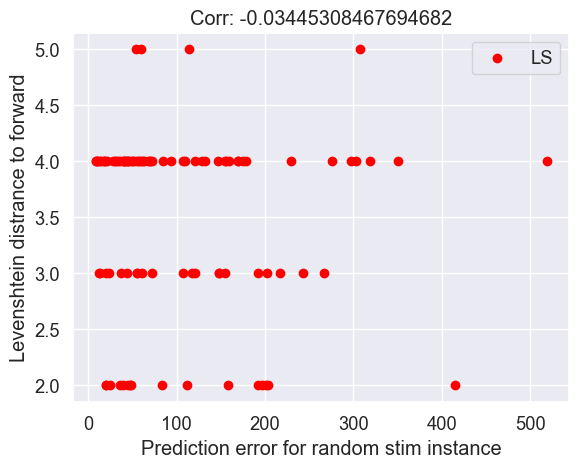

In [49]:
plt.figure()
plt.scatter(LS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)], color='red', label='LS')

plt.xlabel('Prediction error for random stim instance')
plt.ylabel('Levenshtein distrance to forward')
plt.title(f'Corr: {np.corrcoef(LS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)])[0][1]}')
plt.legend()
plt.show()

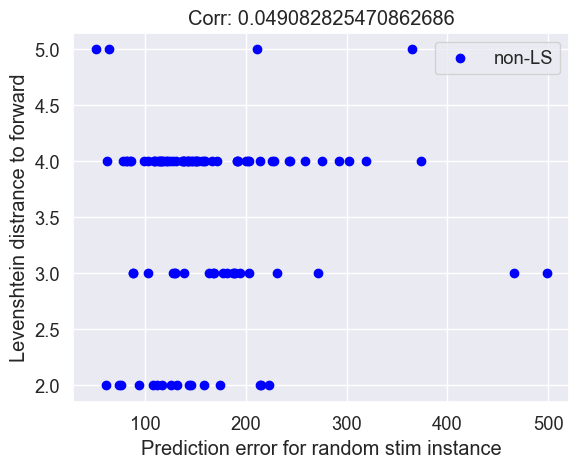

In [50]:
plt.figure()
plt.scatter(nLS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)], color='blue', label='non-LS')
plt.xlabel('Prediction error for random stim instance')
plt.ylabel('Levenshtein distrance to forward')
plt.title(f'Corr: {np.corrcoef(nLS_test_pred_loss.mean(2)[np.array(random_mse_idx),0], np.array(levs_dist)[np.array(random_mse_idx)])[0][1]}')
plt.legend()

plt.show()


<BarContainer object of 98 artists>

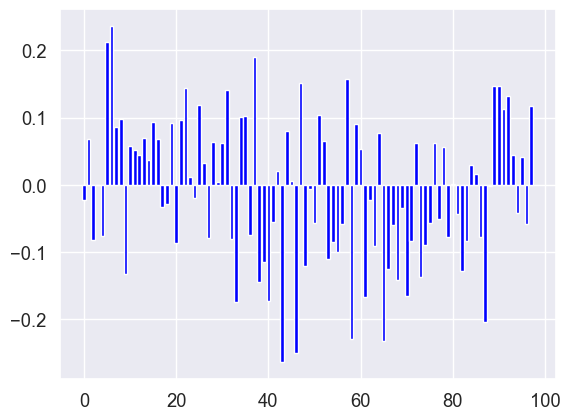

In [52]:
nLS_corrs = [np.corrcoef(nLS_test_pred_loss[np.array(random_mse_idx),0,i], np.array(levs_dist)[np.array(random_mse_idx)])[0][1] for i in range(98)]
    
plt.bar(np.arange(98), nLS_corrs, color='blue')

<BarContainer object of 8 artists>

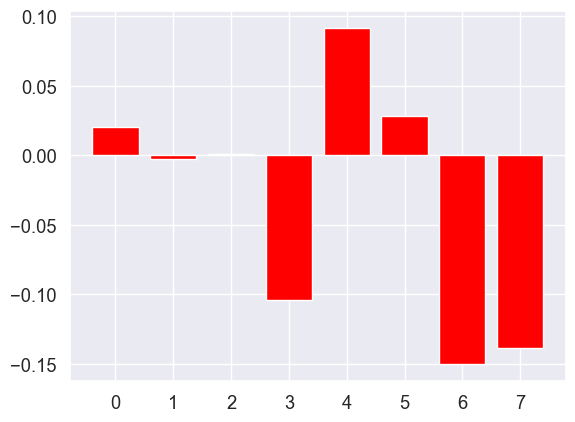

In [54]:
LS_corrs = [np.corrcoef(LS_test_pred_loss[np.array(random_mse_idx),0,i], np.array(levs_dist)[np.array(random_mse_idx)])[0][1] for i in range(8) ]
    
plt.bar(np.arange(8), LS_corrs, color='red')

## Scaling Loss for LS neurons

In [56]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 87        | -99.69    | 262.8     | 478.4     | 5.0       | 1.0       |
# | 65        | -102.9    | 316.6     | 563.4     | 5.0       | 1.0       |
# | 63        | -108.4    | 315.7     | 587.2     | 4.914     | 1.607     |
# | 112       | -111.2    | 139.1     | 926.3     | 4.458     | 9.03      |


d_model = 445
num_heads = 6
hidden_dim = 389
n_layers = 4

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

import random
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

from tqdm import tqdm
from sklearn.linear_model import TweedieRegressor
from loguru import logger

proportion_of_data = [0.05 * i for i in np.arange(20,1,-1)]
proportion_of_data_mean_losses = []
proportion_of_data_std_losses = []
output_dim = len(LS_neuron_idx)

for i, proportion in enumerate(proportion_of_data):
        means = []
        print(proportion)
        rnd_idx = random.sample([i for i in range(len(train_idx))], int(proportion * len(train_idx)))
        batch_size = 1024
        train_dataset = BNN_Dataset(X_train[train_idx, ...][rnd_idx], Y_train_LS[rnd_idx])
        train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
        test_dataset = BNN_Dataset(X_test, Y_test_LS)
        test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=True)

        _DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)

        optimiser = torch.optim.Adam(_DNN_LS.parameters(), lr=1e-3, weight_decay=1e-4)
        criterion = nn.MSELoss(reduction='none')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)
        num_epochs = 500

        _return_dict = train_transformer(
                model=_DNN_LS,
                train_loader=train_dataloader_LS,
                test_loader=test_dataloader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=False,
                force_stop=False,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices=
                [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx])

        _DNN_LS.load_state_dict(_return_dict['best_eval_params'])

        with torch.no_grad():
                _Y_hat_LS = _DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
                _LS_test_pred_loss = nn.MSELoss(reduction='none')(_Y_hat_LS, Y_test[...,LS_neuron_idx])

        # fit GLM with identity link function
        X_train_np = X_train[train_idx, ...][rnd_idx].cpu().numpy().reshape(len(rnd_idx),-1)
        Y_train_LS_np = Y_train_LS[rnd_idx].cpu().numpy().reshape(Y_train_LS[rnd_idx].shape[0],-1) + 1e-6 # numerical stability

        X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
        Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability


        # pred for each neuron
        _glm_LS_losses = np.zeros(Y_test_LS_np.shape[0])

        for i in tqdm(range(output_dim)):
                _glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='identity')
                _glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
                
                _glm_LS_losses += np.power(Y_test_LS_np[:,i] - _glm_LS_reg.predict(X_test_np), 2)
                
        means.append([_LS_test_pred_loss.mean(),
                _LS_test_pred_loss[forward_mse_idx].sum().numpy()/len(forward_mse_idx)/output_dim,
                _LS_test_pred_loss[backward_mse_idx].sum().numpy() / len(backward_mse_idx)/output_dim,
                _LS_test_pred_loss[random_mse_idx].sum().numpy() / len(random_mse_idx)/output_dim,
                _LS_test_pred_loss[non_stim_mse_idx].sum().numpy() / len(non_stim_mse_idx)/output_dim,
                _glm_LS_losses.mean()/output_dim,
                _glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim,
                _glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim,
                _glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim,
                _glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim])
        proportion_of_data_mean_losses.append(np.mean(np.array(means), axis=0))
        proportion_of_data_std_losses.append(np.std(np.array(means), axis=0))

        logger.info(f'Proportion {proportion}, transformer {proportion_of_data_mean_losses[-1][0]}, std {proportion_of_data_std_losses[-1][0]}, glm {proportion_of_data_mean_losses[-1][5]} std {proportion_of_data_std_losses[-1][5]}')

c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


1.0


100%|██████████| 8/8 [00:51<00:00,  6.40s/it]
2024-03-01 00:35:03.376 | INFO     | __main__:<module>:110 - Proportion 1.0, transformer 122.85810089111328, std 0.0, glm 153.0927838996105 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.9500000000000001


100%|██████████| 8/8 [00:49<00:00,  6.21s/it]
2024-03-01 00:37:54.751 | INFO     | __main__:<module>:110 - Proportion 0.9500000000000001, transformer 132.68319702148438, std 0.0, glm 153.60861173479407 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.9


100%|██████████| 8/8 [00:49<00:00,  6.20s/it]
2024-03-01 00:40:54.118 | INFO     | __main__:<module>:110 - Proportion 0.9, transformer 132.7455596923828, std 0.0, glm 153.53251533067814 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.8500000000000001


100%|██████████| 8/8 [00:46<00:00,  5.76s/it]
2024-03-01 00:44:05.102 | INFO     | __main__:<module>:110 - Proportion 0.8500000000000001, transformer 129.5401153564453, std 0.0, glm 153.25314371766305 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.8


100%|██████████| 8/8 [00:43<00:00,  5.38s/it]
2024-03-01 00:46:55.115 | INFO     | __main__:<module>:110 - Proportion 0.8, transformer 133.65106201171875, std 0.0, glm 153.27341529461444 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.75


100%|██████████| 8/8 [00:41<00:00,  5.13s/it]
2024-03-01 00:49:38.788 | INFO     | __main__:<module>:110 - Proportion 0.75, transformer 131.2025604248047, std 0.0, glm 153.70174621396762 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.7000000000000001


100%|██████████| 8/8 [00:36<00:00,  4.53s/it]
2024-03-01 00:51:55.405 | INFO     | __main__:<module>:110 - Proportion 0.7000000000000001, transformer 141.32510375976562, std 0.0, glm 153.8531102378277 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.65


100%|██████████| 8/8 [00:35<00:00,  4.43s/it]
2024-03-01 00:54:05.608 | INFO     | __main__:<module>:110 - Proportion 0.65, transformer 159.32275390625, std 0.0, glm 153.79980998183134 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.6000000000000001


100%|██████████| 8/8 [00:30<00:00,  3.85s/it]
2024-03-01 00:56:29.679 | INFO     | __main__:<module>:110 - Proportion 0.6000000000000001, transformer 142.39651489257812, std 0.0, glm 154.39828254277703 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.55


100%|██████████| 8/8 [00:28<00:00,  3.56s/it]
2024-03-01 00:58:37.531 | INFO     | __main__:<module>:110 - Proportion 0.55, transformer 142.76922607421875, std 0.0, glm 157.3379915572903 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.5


100%|██████████| 8/8 [00:26<00:00,  3.31s/it]
2024-03-01 01:00:28.615 | INFO     | __main__:<module>:110 - Proportion 0.5, transformer 141.0530242919922, std 0.0, glm 156.7341026118219 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.45


100%|██████████| 8/8 [00:21<00:00,  2.74s/it]
2024-03-01 01:02:06.387 | INFO     | __main__:<module>:110 - Proportion 0.45, transformer 156.43238830566406, std 0.0, glm 159.41568368154 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.4


100%|██████████| 8/8 [00:18<00:00,  2.29s/it]
2024-03-01 01:03:45.789 | INFO     | __main__:<module>:110 - Proportion 0.4, transformer 156.0506134033203, std 0.0, glm 162.13175726281165 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.35000000000000003


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]
2024-03-01 01:05:15.467 | INFO     | __main__:<module>:110 - Proportion 0.35000000000000003, transformer 145.7204132080078, std 0.0, glm 159.44096032764787 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.30000000000000004


100%|██████████| 8/8 [00:13<00:00,  1.75s/it]
2024-03-01 01:06:28.066 | INFO     | __main__:<module>:110 - Proportion 0.30000000000000004, transformer 164.58309936523438, std 0.0, glm 164.24858333475976 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.25


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
2024-03-01 01:07:26.851 | INFO     | __main__:<module>:110 - Proportion 0.25, transformer 172.32887268066406, std 0.0, glm 166.4938448854595 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.2


100%|██████████| 8/8 [00:08<00:00,  1.12s/it]
2024-03-01 01:08:37.302 | INFO     | __main__:<module>:110 - Proportion 0.2, transformer 179.35916137695312, std 0.0, glm 167.20944647206755 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.15000000000000002


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
2024-03-01 01:09:29.673 | INFO     | __main__:<module>:110 - Proportion 0.15000000000000002, transformer 196.5262908935547, std 0.0, glm 172.03186396555918 std 0.0
c:\Users\Dan\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


0.1


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]
2024-03-01 01:10:10.228 | INFO     | __main__:<module>:110 - Proportion 0.1, transformer 195.8939971923828, std 0.0, glm 186.20814381250648 std 0.0


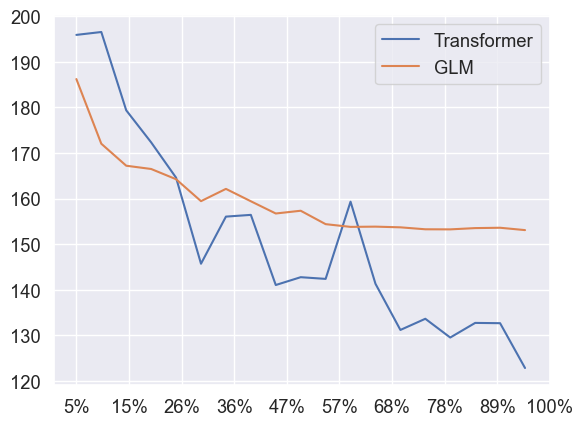

In [57]:
plt.plot([x[0] for x in proportion_of_data_mean_losses][::-1], label='Transformer')
plt.plot([x[5] for x in proportion_of_data_mean_losses][::-1], label='GLM')
plt.legend()
plt.xticks(np.linspace(0, 19, 10), [str(int(i*100))+'%' for i in np.linspace(0.05,1,10)])
plt.show()

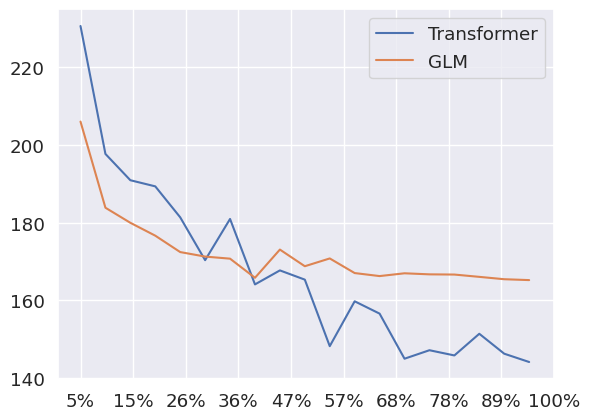

In [80]:
plt.plot([x[0] for x in proportion_of_data_mean_losses][::-1], label='Transformer')
plt.plot([x[5] for x in proportion_of_data_mean_losses][::-1], label='GLM')
plt.legend()
plt.xticks(np.linspace(0, 19, 10), [str(int(i*100))+'%' for i in np.linspace(0.05,1,10)])
plt.show()

In [39]:
LS_param_counts = np.load(save_path / 'EB095_stim_transformer_LS_params_count.npy')

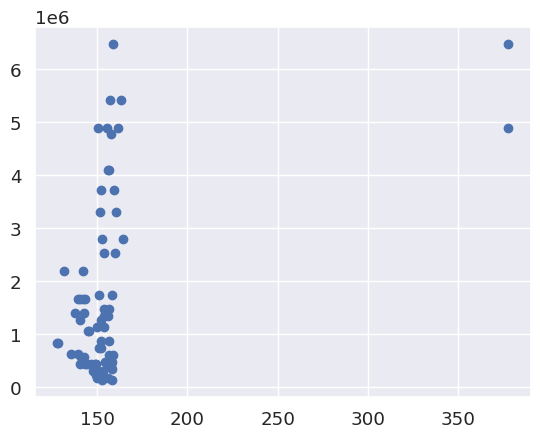

In [45]:
plt.scatter(LS_param_counts[:,0], LS_param_counts[:,1])

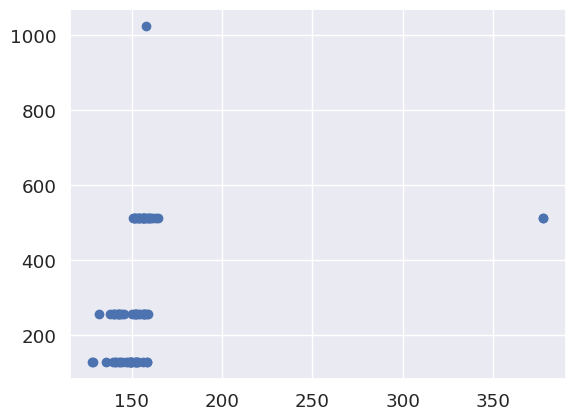

In [42]:
plt.scatter(LS_param_counts[:,0], LS_param_counts[:,2])

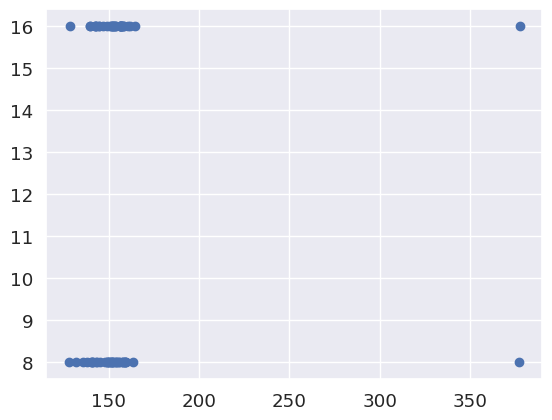

In [43]:
plt.scatter(LS_param_counts[:,0], LS_param_counts[:,3])

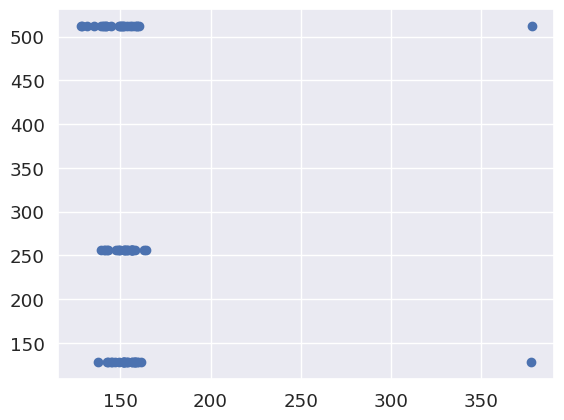

In [44]:
plt.scatter(LS_param_counts[:,0], LS_param_counts[:,4])

## What if we also train on the running data?